#### Imports

In [20]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

Check for CUDA

In [21]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

True
True
cuda


In [22]:
! ls ../Data/
Data_folder_path = "../Data/"
train_df = pd.read_csv(Data_folder_path+"train.csv")
test_df = pd.read_csv(Data_folder_path+"test.csv")

sample_submission.csv  test.csv  train.csv


#### Separate into labels and training images and reshape the images

In [23]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [24]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

#### Plot some images to see samples

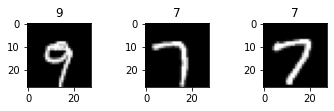

In [25]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

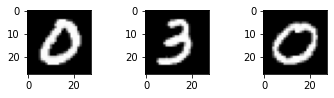

In [26]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

#### Convert images to tensors
Normalize the images too

In [27]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

#### Load images into the data generator

In [28]:
train_loader = DataLoader(train_tensor, batch_size=8, num_workers=0, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=0, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=0, shuffle=False)

#### Plot some sample images using the data generator

/home/azureuser/miniconda3/envs/ef_env/lib/python3.6/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


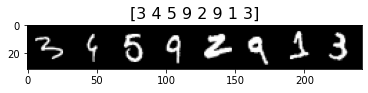

In [29]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

#### Define the CNN Model

In [109]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128*7*7, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x, adjustments=None):
        # First Convolutional Layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        if adjustments is not None and 'conv1' in adjustments:
            x = x + adjustments['conv1']
        
        # Second Convolutional Layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        if adjustments is not None and 'conv2' in adjustments:
            x = x + adjustments['conv2']
        
        x = self.pool1(x)
        
        # Third Convolutional Layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        if adjustments is not None and 'conv3' in adjustments:
            x = x + adjustments['conv3']
        
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # First Fully Connected Layer
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        if adjustments is not None and 'fc1' in adjustments:
            x = x + adjustments['fc1']
        
        # Second Fully Connected Layer
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        if adjustments is not None and 'fc2' in adjustments:
            x = x + adjustments['fc2']
        
        # Output Layer (Do not adjust)
        x = self.dropout3(x)
        x = self.fc3(x)
        
        return x

# Instantiate the model
conv_model = Net()


#### Define the optimizer and loss functions

In [110]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()


#### Training the Model

In [111]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
                
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
                
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data = data.unsqueeze(1)
            
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            
            output = conv_model(data)
            loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


In [112]:
num_epochs = 10

for n in range(num_epochs):
    train_model(n)
    evaluate(val_loader)

Train Epoch: 0 [800/33600 (2%)]	Loss: 1.589806
Train Epoch: 0 [1600/33600 (5%)]	Loss: 1.668469
Train Epoch: 0 [2400/33600 (7%)]	Loss: 0.604120
Train Epoch: 0 [3200/33600 (10%)]	Loss: 1.337416
Train Epoch: 0 [4000/33600 (12%)]	Loss: 0.230074
Train Epoch: 0 [4800/33600 (14%)]	Loss: 0.423348
Train Epoch: 0 [5600/33600 (17%)]	Loss: 0.443601
Train Epoch: 0 [6400/33600 (19%)]	Loss: 0.272487
Train Epoch: 0 [7200/33600 (21%)]	Loss: 0.141826
Train Epoch: 0 [8000/33600 (24%)]	Loss: 0.645023
Train Epoch: 0 [8800/33600 (26%)]	Loss: 0.534558
Train Epoch: 0 [9600/33600 (29%)]	Loss: 0.495124
Train Epoch: 0 [10400/33600 (31%)]	Loss: 0.659189
Train Epoch: 0 [11200/33600 (33%)]	Loss: 0.542258
Train Epoch: 0 [12000/33600 (36%)]	Loss: 0.343066
Train Epoch: 0 [12800/33600 (38%)]	Loss: 0.873143
Train Epoch: 0 [13600/33600 (40%)]	Loss: 0.137561
Train Epoch: 0 [14400/33600 (43%)]	Loss: 0.047371
Train Epoch: 0 [15200/33600 (45%)]	Loss: 0.989732
Train Epoch: 0 [16000/33600 (48%)]	Loss: 0.309987
Train Epoch: 0 [

### Saving the full CNN model

In [113]:
# Save the full model
torch.save(conv_model, 'cnn_full_model.pth')

/home/azureuser/miniconda3/envs/ef_env/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Loading the full CNN model

In [94]:
# To load the full model after the JN has timed out:
conv_model = torch.load('cnn_full_model.pth')
if torch.cuda.is_available():
    conv_model = conv_model.cuda()
conv_model.eval()  # Setting the model to evaluation mode

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn_fc2): BatchNorm1d(64, eps=1e-05, momentum=0

#### Make predictions on the test set (just the CNN)

In [95]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

#Run the inference
test_set_preds = make_predictions(test_loader)

#### Prepare Submissions

In [58]:
submission_df = pd.read_csv("../Data/sample_submission.csv")

In [59]:
submission_df['Label'] = test_set_preds.numpy().squeeze()
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [60]:
submission_df.to_csv('submission.csv', index=False)

### Puppeteer MLP

In [103]:
class PuppeteerNet(nn.Module):
    def __init__(self):
        super(PuppeteerNet, self).__init__()
        
        # Shared Base MLP
        self.base_mlp = nn.Sequential(
            nn.Linear(10, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
        )
        
        # Layer-Specific Adjustment Heads
        # Note: Each adjustment head must handle batch processing
        # conv1 adjustment
        self.conv1_adjustment = nn.Linear(512, 32 * 28 * 28)
        # conv2 adjustment
        self.conv2_adjustment = nn.Linear(512, 64 * 28 * 28)
        # conv3 adjustment
        self.conv3_adjustment = nn.Linear(512, 128 * 14 * 14)
        # fc1 adjustment
        self.fc1_adjustment = nn.Linear(512, 128)
        # fc2 adjustment
        self.fc2_adjustment = nn.Linear(512, 64)
        
        # Activation Function
        self.activation = nn.Tanh()
        
    def forward(self, x):
        base_out = self.base_mlp(x)
        adjustments = {}
        
        # conv1 adjustment
        adj_conv1 = self.conv1_adjustment(base_out)
        adj_conv1 = self.activation(adj_conv1)
        adjustments['conv1'] = adj_conv1.view(-1, 32, 28, 28)
        
        # conv2 adjustment
        adj_conv2 = self.conv2_adjustment(base_out)
        adj_conv2 = self.activation(adj_conv2)
        adjustments['conv2'] = adj_conv2.view(-1, 64, 28, 28)
        
        # conv3 adjustment
        adj_conv3 = self.conv3_adjustment(base_out)
        adj_conv3 = self.activation(adj_conv3)
        adjustments['conv3'] = adj_conv3.view(-1, 128, 14, 14)
        
        # fc1 adjustment
        adj_fc1 = self.fc1_adjustment(base_out)
        adj_fc1 = self.activation(adj_fc1)
        adjustments['fc1'] = adj_fc1  # Shape: [batch_size, 128]
        
        # fc2 adjustment
        adj_fc2 = self.fc2_adjustment(base_out)
        adj_fc2 = self.activation(adj_fc2)
        adjustments['fc2'] = adj_fc2  # Shape: [batch_size, 64]
        
        return adjustments


### Puppeteer model Inference

In [114]:
# Import any required modules
import torch.nn.functional as F

# Training Loop
puppeteer_net = PuppeteerNet()

# Freeze CNN parameters
for param in conv_model.parameters():
    param.requires_grad = False

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    puppeteer_net = puppeteer_net.cuda()
    criterion = criterion.cuda()

# Define optimizer for the Puppeteer MLP
optimizer = optim.Adam(puppeteer_net.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 10

for epoch in range(num_epochs):
    puppeteer_net.train()
    running_total_loss = 0.0
    running_classification_loss = 0.0
    running_inhibition_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_p_inhibited = 0.0  # Sum of probabilities of inhibited digits

    for i, (images, labels) in enumerate(train_loader):
        images = images.unsqueeze(1)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        batch_size = images.size(0)
        
        # Convert labels to LongTensor and create random tensor with matching dtype
        labels = labels.long()
        random_offset = torch.randint(1, 9, (batch_size,), dtype=torch.long, device=labels.device)
        inhibited_digits = (labels + random_offset) % 10
        
        # Convert inhibited digits to one-hot vectors
        inhibited_digits_one_hot = torch.zeros(batch_size, 10).to(images.device)
        inhibited_digits_one_hot.scatter_(1, inhibited_digits.view(-1, 1), 1)
        
        # Get adjustments from Puppeteer MLP
        adjustments = puppeteer_net(inhibited_digits_one_hot)
        
        # Verify that adjustments is a dictionary
        if not isinstance(adjustments, dict):
            raise TypeError("Adjustments must be a dictionary.")
        
        # Forward pass through the CNN with adjustments
        output = conv_model(images, adjustments=adjustments)
        
        # Compute softmax probabilities
        output_probs = F.softmax(output, dim=1)
        
        # Probability of predicting the inhibited digit
        p_inhibited = output_probs[range(batch_size), inhibited_digits]
        
        # Inhibition loss
        epsilon = 1e-6  # Small value to prevent log(0)
        inhibition_loss = -torch.log(1 - p_inhibited + epsilon)
        inhibition_loss = torch.mean(inhibition_loss)
        
        # Classification loss
        classification_loss = criterion(output, labels)
        
        # Total loss
        total_loss = classification_loss + inhibition_loss
        
        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_total_loss += total_loss.item()
        running_classification_loss += classification_loss.item()
        running_inhibition_loss += inhibition_loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        
        # Sum probabilities of inhibited digits
        total_p_inhibited += p_inhibited.sum().item()
        
        # Print training progress
        if (i+1) % 100 == 0:
            avg_accuracy = 100.0 * total_correct / total_samples
            avg_p_inhibited = total_p_inhibited / total_samples
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Total Loss: {running_total_loss/100:.4f}, '
                  f'Classification Loss: {running_classification_loss/100:.4f}, '
                  f'Inhibition Loss: {running_inhibition_loss/100:.4f}, '
                  f'Accuracy: {avg_accuracy:.2f}%, '
                  f'Avg p_inhibited: {avg_p_inhibited:.4f}')
            running_total_loss = 0.0
            running_classification_loss = 0.0
            running_inhibition_loss = 0.0
            total_correct = 0
            total_samples = 0
            total_p_inhibited = 0.0


Epoch [1/10], Step [100/4200], Total Loss: 1.7873, Classification Loss: 1.7591, Inhibition Loss: 0.0282, Accuracy: 74.75%, Avg p_inhibited: 0.0100
Epoch [1/10], Step [200/4200], Total Loss: 1.5494, Classification Loss: 1.5210, Inhibition Loss: 0.0284, Accuracy: 74.25%, Avg p_inhibited: 0.0089
Epoch [1/10], Step [300/4200], Total Loss: 0.9446, Classification Loss: 0.9421, Inhibition Loss: 0.0026, Accuracy: 82.12%, Avg p_inhibited: 0.0023
Epoch [1/10], Step [400/4200], Total Loss: 0.5992, Classification Loss: 0.5954, Inhibition Loss: 0.0038, Accuracy: 87.62%, Avg p_inhibited: 0.0015
Epoch [1/10], Step [500/4200], Total Loss: 0.4391, Classification Loss: 0.4340, Inhibition Loss: 0.0051, Accuracy: 89.38%, Avg p_inhibited: 0.0027
Epoch [1/10], Step [600/4200], Total Loss: 0.4673, Classification Loss: 0.4636, Inhibition Loss: 0.0038, Accuracy: 88.88%, Avg p_inhibited: 0.0031
Epoch [1/10], Step [700/4200], Total Loss: 0.4492, Classification Loss: 0.4476, Inhibition Loss: 0.0017, Accuracy: 89.